In [1]:
import struct
import numpy as np
import cv2
import requests
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, add, concatenate
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

In [2]:
# -------------------- Download Required Files --------------------

!wget https://pjreddie.com/media/files/yolov3.weights  # YOLOv3 pretrained weights
!wget https://github.com/pjreddie/darknet/raw/master/data/dog.jpg  # Sample image

--2025-03-15 21:33:54--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  32.6MB/s    in 7.6s    

2025-03-15 21:34:02 (31.1 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2025-03-15 21:34:02--  https://github.com/pjreddie/darknet/raw/master/data/dog.jpg
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pjreddie/darknet/master/data/dog.jpg [following]
--2025-03-15 21:34:02--  https://raw.githubusercontent.com/pjreddie/darknet/master/data/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)...

In [3]:
# -------------------- Model Architecture --------------------

def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        if conv['stride'] > 1:
            x = ZeroPadding2D(((1,0),(1,0)))(x)
        x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides=conv['stride'],
                   padding='valid' if conv['stride'] > 1 else 'same',
                   name='conv_' + str(conv['layer_idx']),
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
    return add([skip_connection, x]) if skip else x

In [4]:
# We build our architecture and use stride to reduce the size of our image.

# This function defines the YOLOv3 architecture using Keras.
# It uses convolutional blocks (_conv_block) with skip connections, batch normalization, and LeakyReLU activations.
# It creates three detection layers (yolo_82, yolo_94, yolo_106) for detecting objects at different scales.

def make_yolov3_model():
	input_image = Input(shape=(None, None, 3))
	#[1] Layer  0 => 4
	x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
								  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
								  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
								  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
	#[2] Layer  5 => 8
	x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
						{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
	#[3] Layer  9 => 11
	x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
	#[4] Layer 12 => 15
	x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
						{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
						{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
	#[5] Layer 16 => 36
	for i in range(7):
		x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
							{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
	skip_36 = x
	#[6] Layer 37 => 40
	x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
	#[7] Layer 41 => 61
	for i in range(7):
		x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
							{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
	skip_61 = x
	#[8] Layer 62 => 65
	x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
	#[9] Layer 66 => 74
	for i in range(3):
		x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
							{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
	#[10] Layer 75 => 79
	x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
	#[11]. Layer 80 => 82
	yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
							  {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
	#[12] Layer 83 => 86
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_61])
	#[13] Layer 87 => 91
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
	#[14] Layer 92 => 94
	yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
							  {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
	#[15] Layer 95 => 98
	x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_36])
	#[16] Layer 99 => 106
	yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
							   {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
	model = Model(input_image, [yolo_82, yolo_94, yolo_106])
	return model

In [5]:
# -------------------- Weight Loading --------------------

# We read and load the weights of the coco dataset [https://cocodataset.org/#home] trained by darknet.
# Darknet is an open-source neural network framework written in C and CUDA [https://pjreddie.com/darknet/].

# This class loads the pre-trained YOLOv3 weights (downloaded from yolov3.weights).
# It handles the binary weight format and correctly assigns weights to the model layers.

class WeightReader:
	def __init__(self, weight_file):
		with open(weight_file, 'rb') as w_f:
			major,	= struct.unpack('i', w_f.read(4))
			minor,	= struct.unpack('i', w_f.read(4))
			revision, = struct.unpack('i', w_f.read(4))
			if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
				w_f.read(8)
			else:
				w_f.read(4)
			transpose = (major > 1000) or (minor > 1000)
			binary = w_f.read()
		self.offset = 0
		self.all_weights = np.frombuffer(binary, dtype='float32')

	def read_bytes(self, size):
		self.offset = self.offset + size
		return self.all_weights[self.offset-size:self.offset]

	def load_weights(self, model):
		for i in range(106):
			try:
				conv_layer = model.get_layer('conv_' + str(i))
				print("loading weights of convolution #" + str(i))
				if i not in [81, 93, 105]:
					norm_layer = model.get_layer('bnorm_' + str(i))
					size = np.prod(norm_layer.get_weights()[0].shape)
					beta  = self.read_bytes(size)
					gamma = self.read_bytes(size)
					mean  = self.read_bytes(size)
					var   = self.read_bytes(size)
					weights = norm_layer.set_weights([gamma, beta, mean, var])
				if len(conv_layer.get_weights()) > 1:
					bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel, bias])
				else:
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel])
			except ValueError:
				print("no convolution #" + str(i))

	def reset(self):
		self.offset = 0

In [6]:
# -------------------- Model Initialization --------------------

model = make_yolov3_model()
weight_reader = WeightReader('yolov3.weights')
weight_reader.load_weights(model)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [7]:
# -------------------- Detection Utilities --------------------

# First, we will draw bounding boxes with the class BoundBox.
# Then we obtain our labels with the get label function.
# Finally, we compute the probability of each class with the get score function.

# BoundBox: A class to represent bounding boxes with objectness and class probabilities.

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness=None, classes=None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        return self.score

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [8]:
# We obtain all boxes

# decode_netout: Decodes the raw model output into bounding boxes.

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh

	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):

			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue

			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w
			y = (row + y) / grid_h
			w = anchors[2 * b + 0] * np.exp(w) / net_w
			h = anchors[2 * b + 1] * np.exp(h) / net_h

			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

# correct_yolo_boxes: Corrects box coordinates to match the original image size.

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [9]:
# We compute the IOU = Intersection/Union

def _interval_overlap(interval_a, interval_b):
    """Calculates the overlap between two intervals."""
    x1, x2 = interval_a
    x3, x4 = interval_b

    # Ensure intervals are valid
    if x1 > x2 or x3 > x4:
        return 0  # No overlap for invalid intervals

    # Calculate overlap
    if x3 < x1:
        if x4 < x1:
            return 0  # No overlap
        else:
            return min(x2, x4) - x1
    else:
        if x2 < x3:
            return 0  # No overlap
        else:
            return min(x2, x4) - x3

# bbox_iou: Calculates the Intersection over Union (IOU) between two bounding boxes.

def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h


	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin


	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union

In [10]:
# We use Non-Maximum Suppression (NMS) to omit multiple detected boxes for one object.

# do_nms: Performs Non-Maximum Suppression (NMS) to remove redundant overlapping boxes.

def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0

In [11]:
# -------------------- Image Processing --------------------

# We make our image ready by resizing and rescaling it.
# Then we will make it into an numpy array.

# load_image_pixels: Loads and preprocesses an image (resizing, normalization).

def load_image_pixels(filename, shape):
    image = load_img(filename)
    width, height = image.size
    image = load_img(filename, target_size=shape)
    image = img_to_array(image)
    image = image.astype('float32')
    image /= 255.0
    image = np.expand_dims(image, 0)
    return image, width, height

In [12]:
# -------------------- Main Detection Pipeline --------------------

# Load and process image
# We store our image and make it into [image, width, height].

input_w, input_h = 416, 416
photo_filename = 'dog.jpg'
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h)) # Loads the image using load_image_pixels.

In [13]:
# Make prediction
yhat = model.predict(image) # Performs object detection using model.predict.

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [14]:
# Define anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# Anchor boxes are predefined boxes with a certain height and width.
# If we have multiple objects in the same cell, we will associate each object with one of the anchor boxes.
# If an anchor box does not have an associated object, it will have a confidence score of zero.

# Define class labels (COCO dataset)
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
          "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
          "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
          "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
          "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
          "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
          "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
          "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
          "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
          "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

In [15]:
# Process outputs
boxes = []
for i in range(len(yhat)):
    boxes += decode_netout(yhat[i][0], anchors[i], 0.5, input_h, input_w)

correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
do_nms(boxes, 0.5)

# Get detection results
v_boxes, v_labels, v_scores = [], [], []
for box in boxes:
    for i in range(len(labels)):
        if box.classes[i] > 0.5:
            v_boxes.append(box)
            v_labels.append(labels[i])
            v_scores.append(box.classes[i]*100)

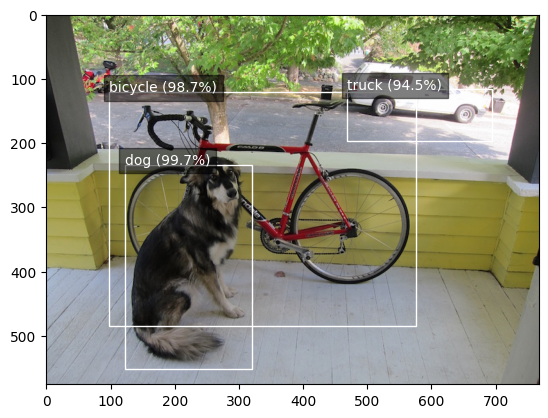

In [16]:
# -------------------- Visualization --------------------

# Load image
data = pyplot.imread(photo_filename)
pyplot.imshow(data)
ax = pyplot.gca()

# Draw bounding boxes
for i in range(len(v_boxes)):
    box = v_boxes[i]
    y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
    width, height = x2 - x1, y2 - y1
    rect = Rectangle((x1, y1), width, height, fill=False, color='white')
    ax.add_patch(rect)
    label = "%s (%.1f%%)" % (v_labels[i], v_scores[i])
    pyplot.text(x1, y1, label, color='white', bbox=dict(facecolor='black', alpha=0.5))

pyplot.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


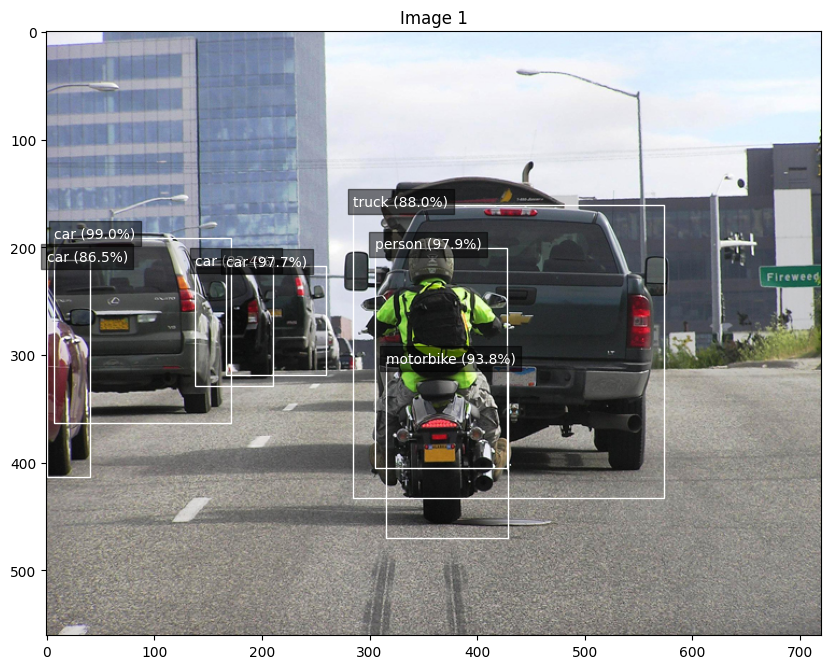

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


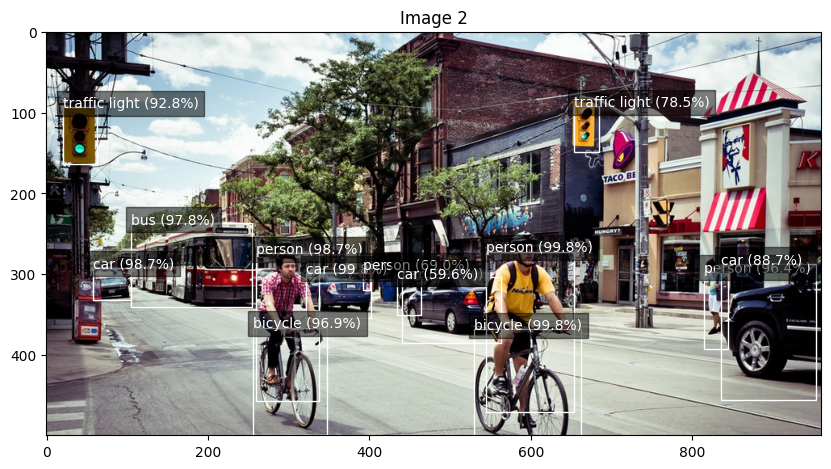

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


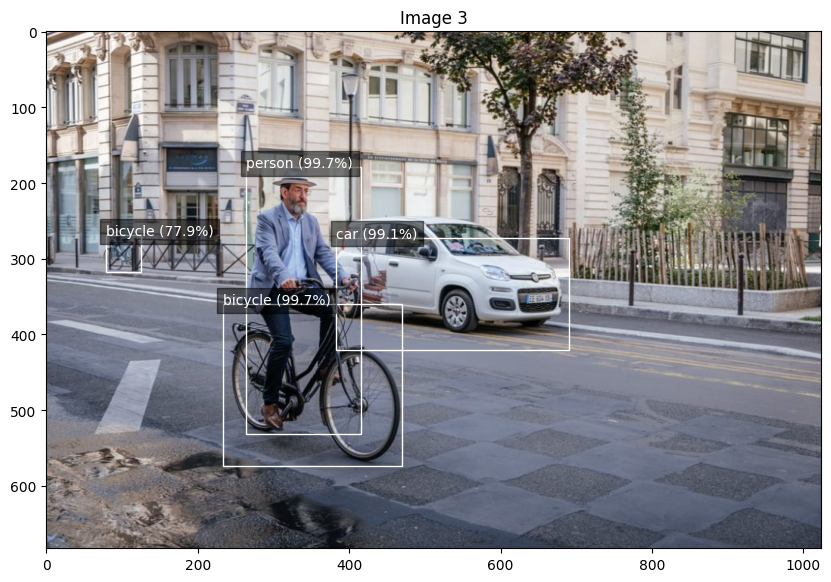

In [18]:
from google.colab import drive  # For Google Colab only

# Step 1: Mount Google Drive (for Google Colab)
drive.mount('/content/drive')

# Step 2: Define paths to the three images in Google Drive
image_paths = [
    '/content/drive/MyDrive/AI/s2.jpg',
    '/content/drive/MyDrive/AI/scene3.jpg',
    '/content/drive/MyDrive/AI/cycling001-1024x683.jpg'
]

# Step 3: Loop through each image path and process it
for idx, photo_filename in enumerate(image_paths):
    # Load and process image
    image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

    # Make prediction
    yhat = model.predict(image)

    # Process outputs
    boxes = []
    for i in range(len(yhat)):
        boxes += decode_netout(yhat[i][0], anchors[i], 0.5, input_h, input_w)

    correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
    do_nms(boxes, 0.5)

    # Get detection results for the current image
    v_boxes, v_labels, v_scores = [], [], []
    for box in boxes:
        for i in range(len(labels)):
            if box.classes[i] > 0.5:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)

    # Load image
    data = pyplot.imread(photo_filename)

    # Display the image
    pyplot.figure(figsize=(10, 10))  # Optional: Adjust figure size
    pyplot.imshow(data)
    ax = pyplot.gca()

    # Draw bounding boxes
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        width, height = x2 - x1, y2 - y1
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        ax.add_patch(rect)
        label = "%s (%.1f%%)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white', bbox=dict(facecolor='black', alpha=0.5))

    # Show the final visualization for the current image
    pyplot.title(f"Image {idx + 1}")  # Add a title for clarity
    pyplot.show()